In [ ]:
!unzip /content/Test.zip

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import keras
import PIL
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tqdm.notebook import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0

In [4]:
IMG_SIZE=224
NUM_CLASSES=43

In [10]:

img_augmentation = Sequential(
    [
          preprocessing.RandomRotation(factor=0.2),
        preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
        #preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.2),
    ],
    name="img_augmentation",
)

In [11]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (224, 224) + (3,)
#base_model = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE,
#                                               include_top=False,
#                                               weights='imagenet')
base_model = EfficientNetB0(include_top=False, weights='imagenet')


16711680/16705208 [==============================] - 0s 0us/step


In [14]:
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [15]:
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [16]:
  inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = img_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  base_learning_rate = 0.001
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

In [17]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [18]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 43)                55083     
Total params: 4,104,654
Trainable params: 3,342,787
Non-trainable params: 761,867
_____________________________________________

In [20]:
weights_path='/content/drive/MyDrive/weights_resnet.hdf5'
# m=keras.models.load_model('/content/drive/MyDrive/weights_resnet.hdf5')
from keras.models import load_model
# model1 = load_model('/content/drive/MyDrive/weights_resnet.hdf5')
model.load_weights(weights_path)

In [54]:
import pandas as pd
test = pd.read_csv('/content/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

In [25]:
import cv2
from PIL import Image

In [55]:
for img in imgs:
    try:
        image = cv2.imread('/content' + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((224, 224))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)

In [ ]:
len(X_test)

In [46]:
out= model.predict(X_test)
pred = np.argmax(out, axis=-1)

In [44]:
from sklearn.metrics import accuracy_score

In [103]:
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  81.21140142517814


In [50]:
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  81.21140142517814


In [150]:
# wrongly classified images
wr_cl=[]
wr_ci=[]
for i in range(len(labels)):
  if labels[i]!= pred[i]:
    wr_ci.append(X_test[i])
    wr_cl.append(labels[i])

In [151]:
len(wr_cl)

2373

In [133]:
def occlusion(model, image, label, occ_size=50, occ_stride=50, occ_pixel=0.5):
    
    # width, height = image.shape[-2], image.shape[-1]
    
    width, height = 224, 224

    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
    
    heatmap = np.zeros((output_height, output_width))
    
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            input_image = np.copy(image)
            input_image[ w_start:w_end, h_start:h_end,:] = occ_pixel
            output= model.predict(input_image.reshape(1,224,224,3))
            prob= output[0][label]
            heatmap[h, w] = prob 

    return heatmap, max(output[0])

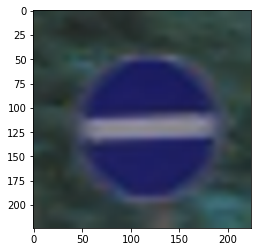

In [162]:
i=4
occ_image= wr_ci[i]
occ_label= wr_cl[i]
plt.imshow(occ_image )

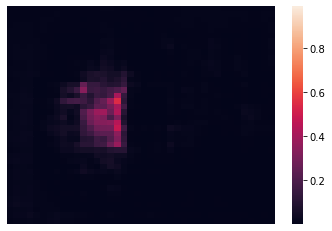

In [163]:
heatmap, prob_no_occ = occlusion(model, occ_image , occ_label , 25, 5)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)

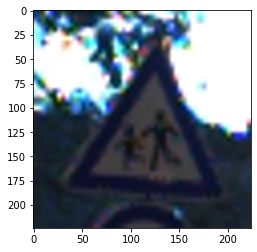

In [143]:
i=10
occ_image= wr_ci[i]
occ_label= wr_cl[i]
plt.imshow(occ_image )

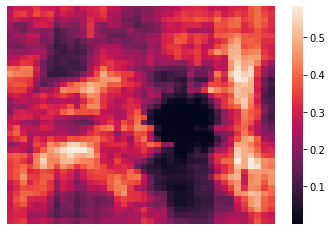

In [144]:
heatmap, prob_no_occ = occlusion(model, occ_image , occ_label , 25, 5)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)

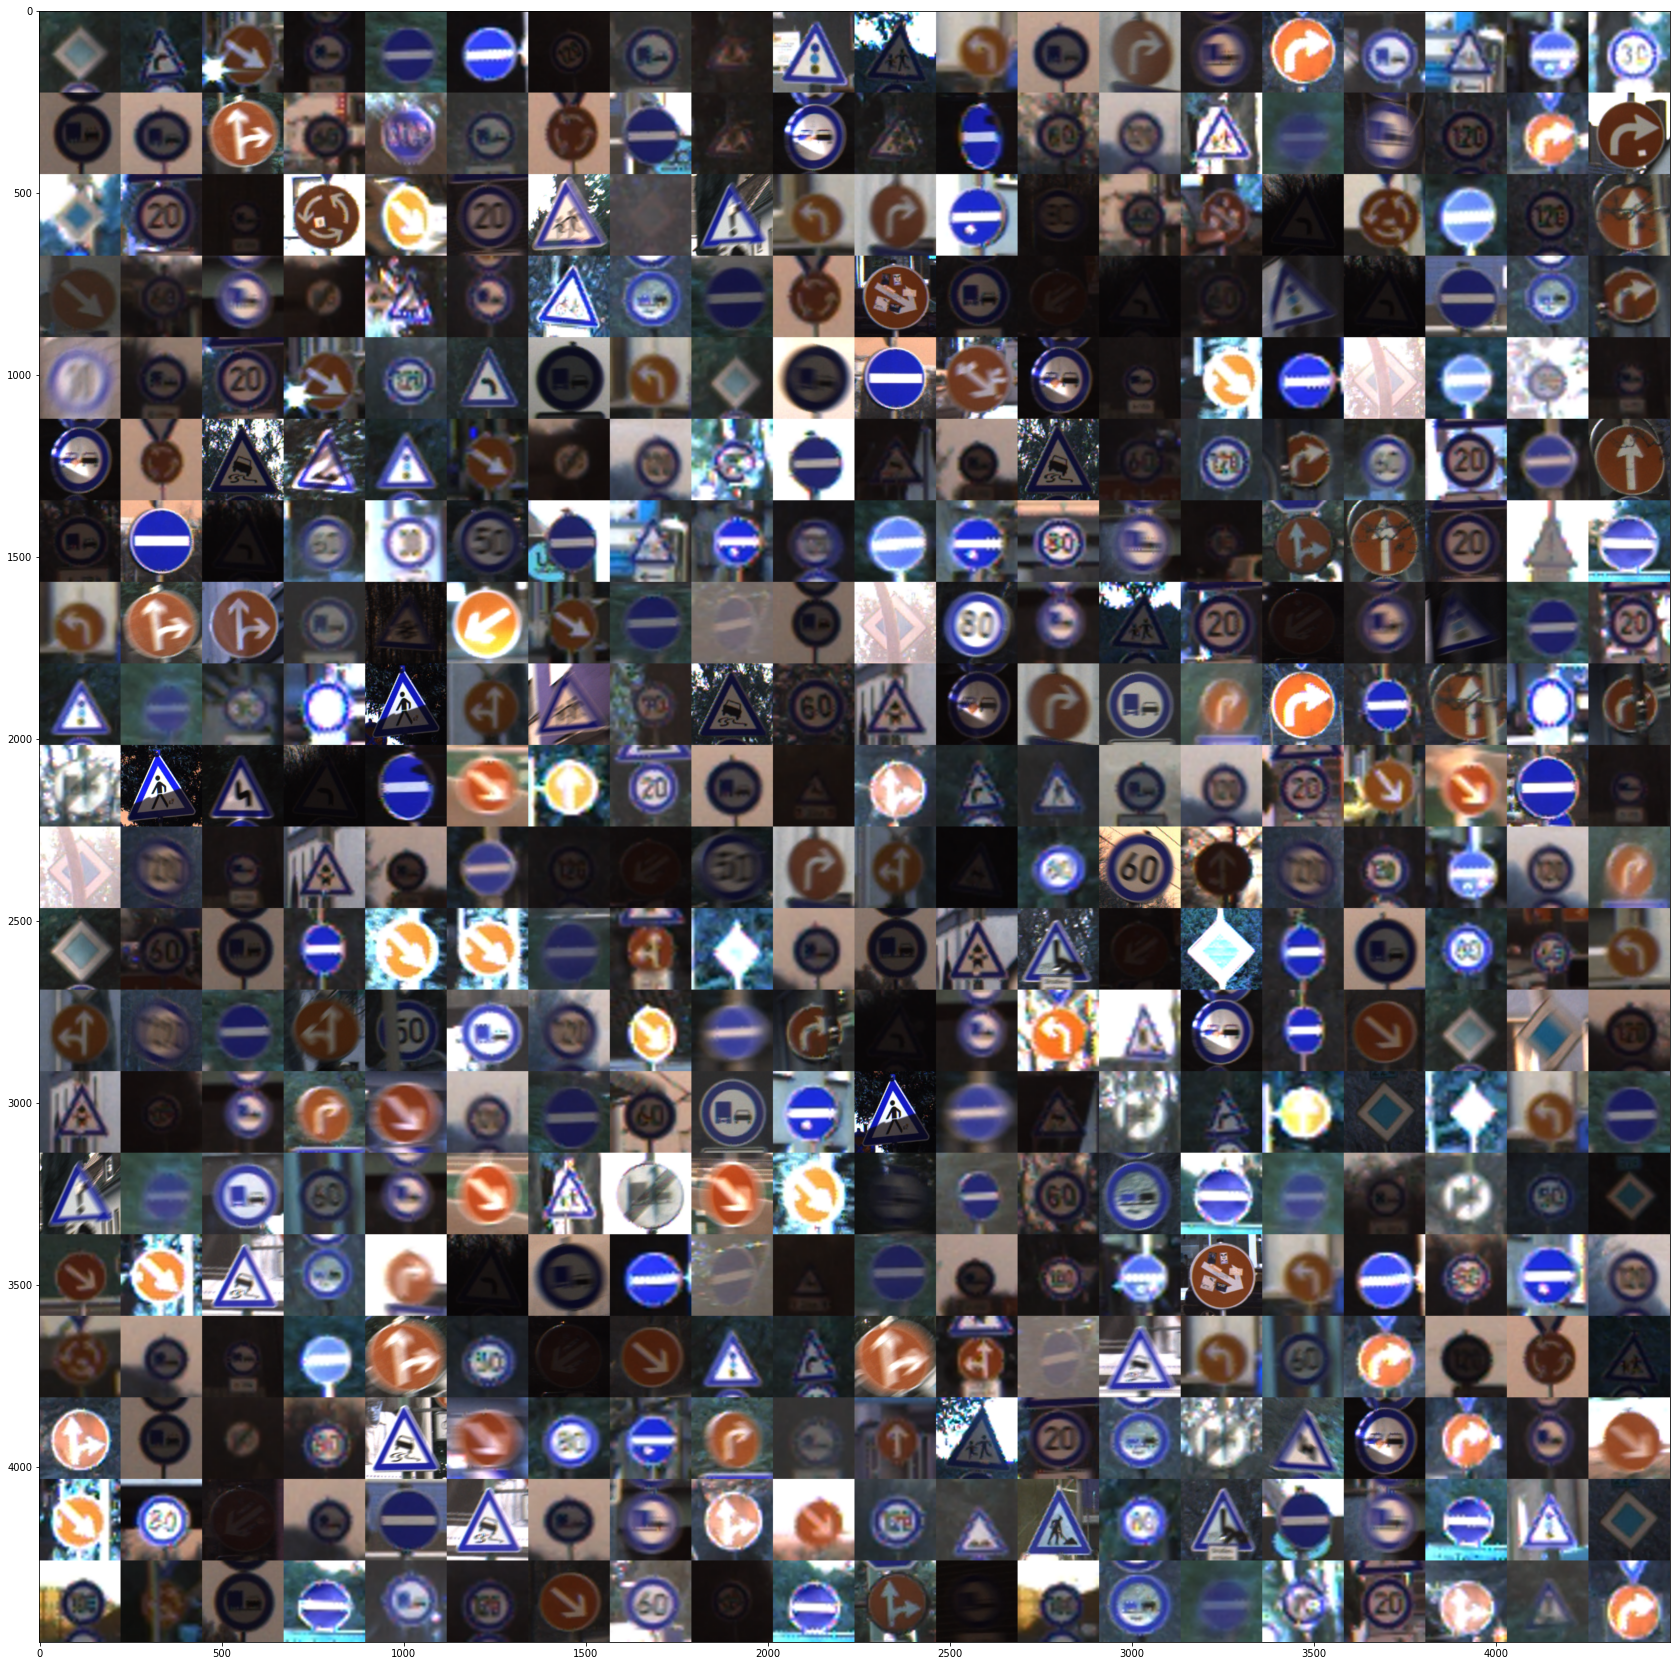

In [161]:
plt.figure(figsize = (30,30))
r=20
c=20
plt.imshow(np.array(wr_ci[:r*c]).reshape(r,c , 224, 224, 3)
              .swapaxes(1,2)
              .reshape(224*r, 224*c, 3))